
# Repeat Themes in Kanye West’s Lyrics: Wealth, Religion, and Relationships

Using the Kaggle dataset: > `convolutionalnn/kanye-west-lyrics-dataset`

This script does the following:

1. Data download and loading (via `kagglehub`)
2. Text preprocessing (tokenization, stopword removal, lemmatization)
3. Word frequency analysis
4. Sentiment analysis (VADER)
5. Word co-occurrence network (NetworkX)
6. Topic modeling (LDA)
7. Word clouds (overall and per album)
8. Theme keyword analysis (wealth, religion, relationships)



## 1. Setup and Library Installation

In [66]:
#!pip install kagglehub
#!pip install pandas matplotlib seaborn nltk networkx gensim wordcloud
#!pip install wordcloud

  
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

import string
import networkx as nx
import csv


from wordcloud import WordCloud
from gensim import corpora
from gensim.models import LdaModel

import kagglehub
import re

from collections import Counter
import itertools


# Make plots a bit nicer
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# Download NLTK resources (safe to run multiple times)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('vader_lexicon', quiet=True)


True


## 2. Download the Kanye West Lyrics Dataset from Kaggle.

I used `kagglehub` to automatically download the latest version of the dataset from Kaggle.

In [67]:

# Download latest version of the dataset from Kaggle
dataset_dir = kagglehub.dataset_download("convolutionalnn/kanye-west-lyrics-dataset")
print("Dataset directory:", dataset_dir)

# Inspect files in the dataset directory
files = os.listdir(dataset_dir)
print("Files found in dataset directory:", files)

# Automatically pick the first .txt or .csv file
data_file = None
for f in files:
    if f.lower().endswith(".txt") or f.lower().endswith(".csv"):
        data_file = os.path.join(dataset_dir, f)
        break

if data_file is None:
    raise FileNotFoundError("No .txt or .csv file found in the dataset directory. Check Kaggle dataset contents.")

print("Using data file:", data_file)


Dataset directory: C:\Users\hotga\.cache\kagglehub\datasets\convolutionalnn\kanye-west-lyrics-dataset\versions\1
Files found in dataset directory: ['Kanye West Lyrics.txt']
Using data file: C:\Users\hotga\.cache\kagglehub\datasets\convolutionalnn\kanye-west-lyrics-dataset\versions\1\Kanye West Lyrics.txt



## 3. Load and Inspect the Dataset

The dataset file may be in `.txt` or `.csv` format.  
I will try to read it as a regular CSV first, and if that fails, we try tab-separated text.

Also, I normalized column names to lowercase and ensure that there is a `lyrics` column.


In [68]:
def load_dataset(file_path: str) -> pd.DataFrame:
    """
    Load the Kanye West lyrics dataset from the Kaggle text file.

    The original dataset is a single .txt file, not a structured CSV table.

    1. Read the entire file as raw text.
    2. Split the text into blocks separated by blank lines.
       (Each block is treated as one song/verse document.)
    3. Return a DataFrame with a single column: 'lyrics'.
    """
    print("Loading raw text from:", file_path)

    # Read the file as plain text
    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
        text = f.read()

    # Split on double newlines -> each block ~ one song/verse
    blocks = [b.strip() for b in text.split("\n\n") if b.strip()]

    print(f"Total text blocks (approx songs/verses): {len(blocks)}")

    df = pd.DataFrame({"lyrics": blocks})

    print("DataFrame shape:", df.shape)
    print("Columns:", df.columns.tolist())

    return df


df = load_dataset(data_file)

# Quick peek
df.head()

Loading raw text from: C:\Users\hotga\.cache\kagglehub\datasets\convolutionalnn\kanye-west-lyrics-dataset\versions\1\Kanye West Lyrics.txt
Total text blocks (approx songs/verses): 944
DataFrame shape: (944, 1)
Columns: ['lyrics']


,lyrics
0,"﻿[Chorus]\nSing every hour (Every hour, 'til t..."
1,[Verse]\nSing 'til the power of the Lord comes...
2,"[Chorus]\nSing every hour (Every hour, 'til th..."
3,[Bridge]\nSing 'til the power of the Lord come...
4,"[Chorus]\nSing every hour (Every hour, 'til th..."



## 4. Text Preprocessing: Tokenization, Stopwords, Lemmatization

To prepare the lyrics for analysis:

- Convert text to lowercase  
- Remove punctuation  
- Tokenize into words  
- Remove English stopwords ('the', 'and')  
- Lemmatize words to their base form ('running' → 'run')  

This results in a normalized `tokens` column I can use for all analysis.


In [69]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text: str):
    # ----------------------------------------------
    # 1. Remove anything inside square brackets
    #    Examples removed:
    #    [Chorus], [Verse 2: Kanye West], [Outro: Kanye & Choir]
    # ----------------------------------------------
    text = re.sub(r"\[.*?\]", "", text)

    # 2. Lowercase
    text = text.lower()

    # 3. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 4. Tokenize
    tokens = word_tokenize(text)

    # 5. Remove stopwords and short tokens
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]

    # 6. Lemmatize words to base form
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return tokens

df["tokens"] = df["lyrics"].apply(clean_text)



## 5. Word Frequency Analysis

Examine the most frequently used words across Kanye's lyrics.

This helps me see which concepts are dominant in his vocabulary.


Top 30 most common words:
like: 496
know: 492
get: 447
got: 405
dont: 366
nigga: 266
aint: 239
cant: 238
say: 233
see: 230
yeah: 227
let: 221
gon: 213
make: 212
love: 209
thats: 208
need: 207
right: 200
shit: 200
man: 182
never: 180
one: 177
feel: 168
cause: 162
back: 160
girl: 155
god: 147
thing: 146
life: 146
time: 146


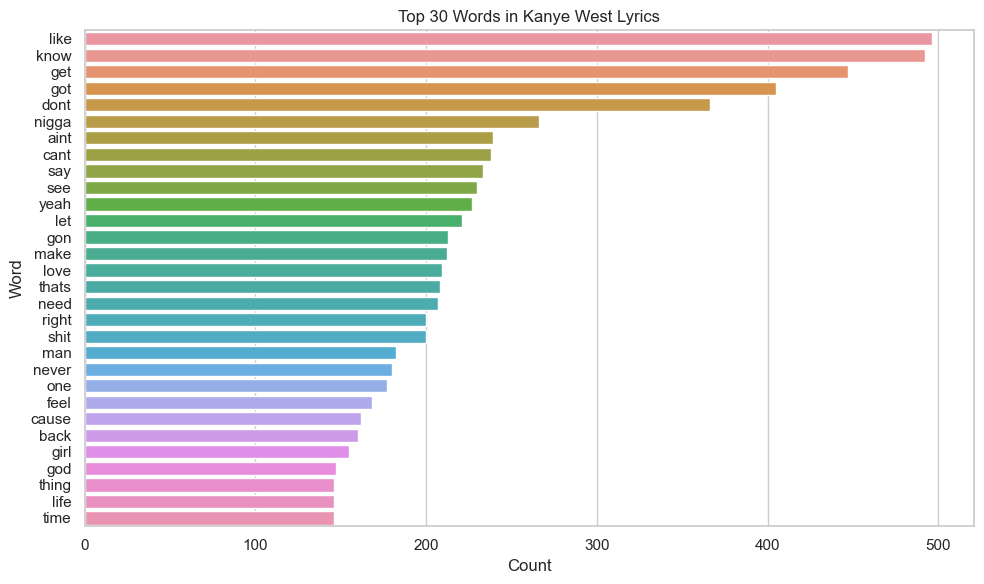

In [70]:
def analyze_word_frequencies(df: pd.DataFrame, top_n: int = 30):
    all_tokens = [token for sublist in df["tokens"] for token in sublist]
    freq = Counter(all_tokens)
    common = freq.most_common(top_n)
    
    print(f"Top {top_n} most common words:")
    for word, count in common:
        print(f"{word}: {count}")
    
    words, counts = zip(*common)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f"Top {top_n} Words in Kanye West Lyrics")
    plt.xlabel("Count")
    plt.ylabel("Word")
    plt.tight_layout()
    plt.show()

analyze_word_frequencies(df, top_n=30)



## 6. Sentiment Analysis (VADER)

NLTK's VADER sentiment analyzer to measure:

- Negative (`neg`)  
- Neutral (`neu`)  
- Positive (`pos`)  
- Overall compound score (`compound`)  

for each lyrics entry. This gives me a sense of the emotional tone of Kanye's songs.


Example sentiment scores:


,lyrics,neg,neu,pos,compound
0,"﻿[Chorus]\nSing every hour (Every hour, 'til t...",0.0,1.000,0.000,0.0000
1,[Verse]\nSing 'til the power of the Lord comes...,0.0,0.893,0.107,0.9601
2,"[Chorus]\nSing every hour (Every hour, 'til th...",0.0,1.000,0.000,0.0000


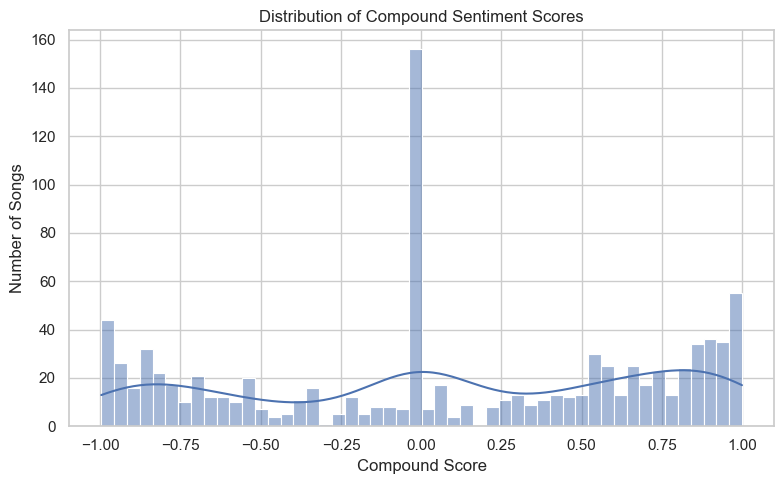

In [71]:
def run_sentiment_analysis(df: pd.DataFrame) -> pd.DataFrame:
    sia = SentimentIntensityAnalyzer()
    sentiment_dicts = df["lyrics"].apply(sia.polarity_scores)
    sentiment_df = pd.json_normalize(sentiment_dicts)
    df_sent = pd.concat([df.reset_index(drop=True), sentiment_df], axis=1)
    
    print("Example sentiment scores:")
    display(df_sent[["lyrics", "neg", "neu", "pos", "compound"]].head(3))
    
    # Plot distribution of compound scores
    plt.figure(figsize=(8, 5))
    sns.histplot(df_sent["compound"], bins=50, kde=True)
    plt.title("Distribution of Compound Sentiment Scores")
    plt.xlabel("Compound Score")
    plt.ylabel("Number of Songs")
    plt.tight_layout()
    plt.show()
    
    # If album info exists, show sentiment by album
    if "album" in df_sent.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df_sent, x="album", y="compound")
        plt.xticks(rotation=45, ha="right")
        plt.title("Sentiment (Compound) by Album")
        plt.tight_layout()
        plt.show()
    
    return df_sent

df = run_sentiment_analysis(df)



## 7. Word Cloud (Global Only)

The dataset does not include album info, so I generated **only a global word cloud** using the cleaned tokens (with bracketed sections like [Chorus] removed).


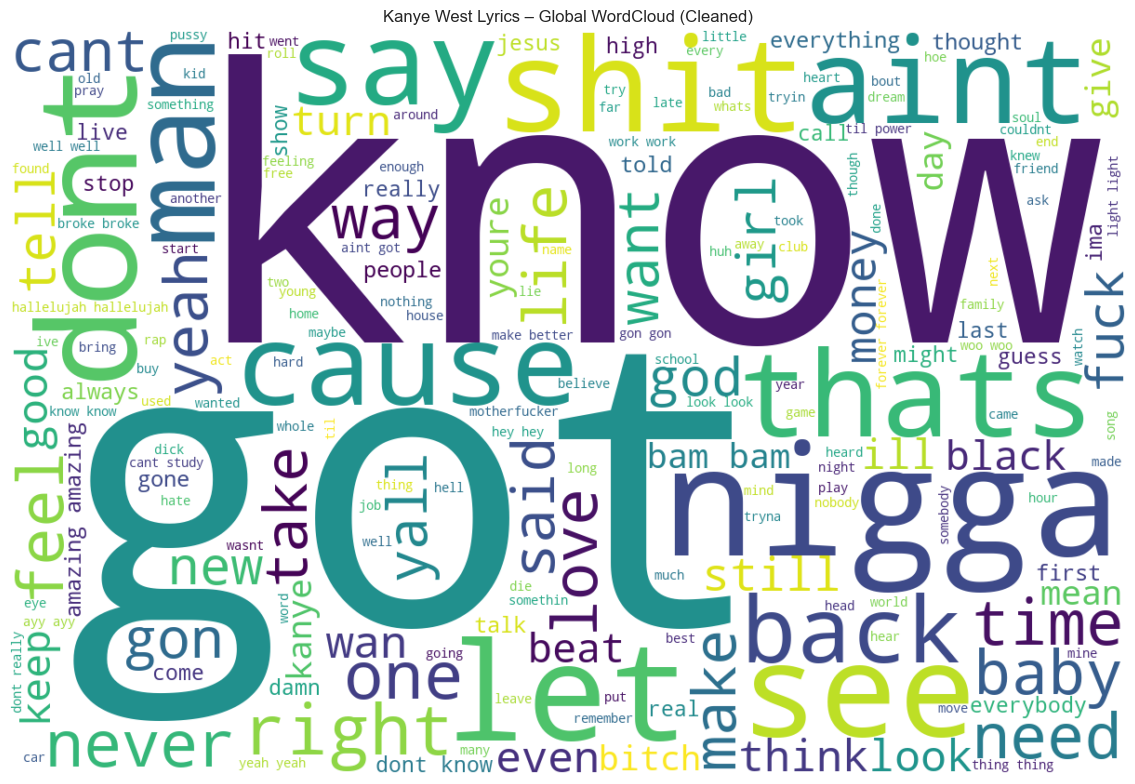

In [72]:
def generate_global_wordcloud(df: pd.DataFrame):
    # Build a single big string from cleaned tokens
    all_tokens = [token for sublist in df["tokens"] for token in sublist]
    all_text = " ".join(all_tokens)

    wc = WordCloud(
        width=1200,
        height=800,
        background_color="white"
    ).generate(all_text)

    plt.figure(figsize=(12, 8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Kanye West Lyrics – Global WordCloud (Cleaned)")
    plt.tight_layout()
    plt.show()


generate_global_wordcloud(df)



## 8. Theme Keyword Analysis: Wealth, Religion, Relationships

To directly test the hypothesis:

1. Define keyword lists for each theme.  
2. Count how many times theme-related words appear in each song.  

In [73]:
# 1. Theme keyword lists
THEMES = {
    "wealth": [
    "money", "cash", "gold", "rich", "bank", "wealth", "luxury", "designer",
    "ice", "diamond", "diamonds", "fame", "famous", "chain", "chains",
    "rollie", "roli", "rolie", "watch", "rolls", "phantom", "benz", "bugatti",
    "dollars", "stacks", "band", "bands", "grand", "credit", "irs", "income",
    "tax", "taxes", "tithe",
    "yacht", "mansion", "jet", "private",
    "lavish", "ballin", "stunt", "flex", "drip"
],
    "religion": [
    "god", "jesus", "lord", "heaven", "hell", "holy", "spirit", "faith",
    "pray", "prayer", "worship", "praise", "hallelujah", "gospel", "choir",
    "church", "amen", "blessing", "blessings", "salvation", "grace",
    "forgive", "forgiveness", "sin", "sins", "scripture",
    "angel", "angels", "devil", "demons",
    "abraham", "noah", "judas",
    "saint", "ultrabeam", "hallelujah", "christ", "jesus", "christ-like"
],
    "relationships": [
    "love", "lover", "loving", "heart", "kiss", "girl", "girls", "woman",
    "women", "girlfriend", "boy", "relationship", "wife", "husband", "baby",
    "romance", "together", "family", "mama", "dad", "daddy", "daughter",
    "son", "brother", "sister", "cousin",
    "touch", "feel", "feelings", "affection", "desire",
    "argue", "fight", "breakup", "leave", "stay", "trust",
    "sex", "freak", "body", "titties", "thot", "thots", "ass"
],
}

THEME_SETS = {name: set(words) for name, words in THEMES.items()}

def theme_count(tokens, keyword_set):
    """Count how many tokens in this song belong to a theme."""
    return sum(1 for t in tokens if t in keyword_set)

def add_theme_counts(df: pd.DataFrame) -> pd.DataFrame:
    for theme_name, keyword_set in THEME_SETS.items():
        col_name = f"{theme_name}_count"
        df[col_name] = df["tokens"].apply(
            lambda tokens: theme_count(tokens, keyword_set)
        )
    return df

# Recompute counts
df = add_theme_counts(df)

# Quick view of the 3 theme columns (first 10 songs)
df[[c for c in df.columns if c.endswith("_count")]].head(10)

# --- TOTAL COUNTS ACROSS THE ENTIRE CORPUS ---
theme_cols = ["wealth_count", "religion_count", "relationships_count"]

print("=== TOTAL THEME COUNTS ACROSS ALL SONGS ===")
total_theme_counts = df[theme_cols].sum()
print(total_theme_counts)


summary_df = pd.DataFrame({
    "Theme": ["Wealth", "Religion", "Relationships"],
    "Total Keyword Count": [
        total_theme_counts["wealth_count"],
        total_theme_counts["religion_count"],
        total_theme_counts["relationships_count"]
    ]
})

summary_df



=== TOTAL THEME COUNTS ACROSS ALL SONGS ===
wealth_count            302
religion_count          494
relationships_count    1141
dtype: int64


,Theme,Total Keyword Count
0,Wealth,302
1,Religion,494
2,Relationships,1141



## 9. Word Co-occurrence Network (Network Analysis)

To tackle the **network analysis** component, I built a graph where:

- Nodes = words  
- Edges = words that appear together in the same song  
- Edge weight = how many songs the word pair co-occurs in  

I applied a threshold to filter out weak connections so the network is more interpretable.


Nodes plotted: 35
Edges plotted: 595


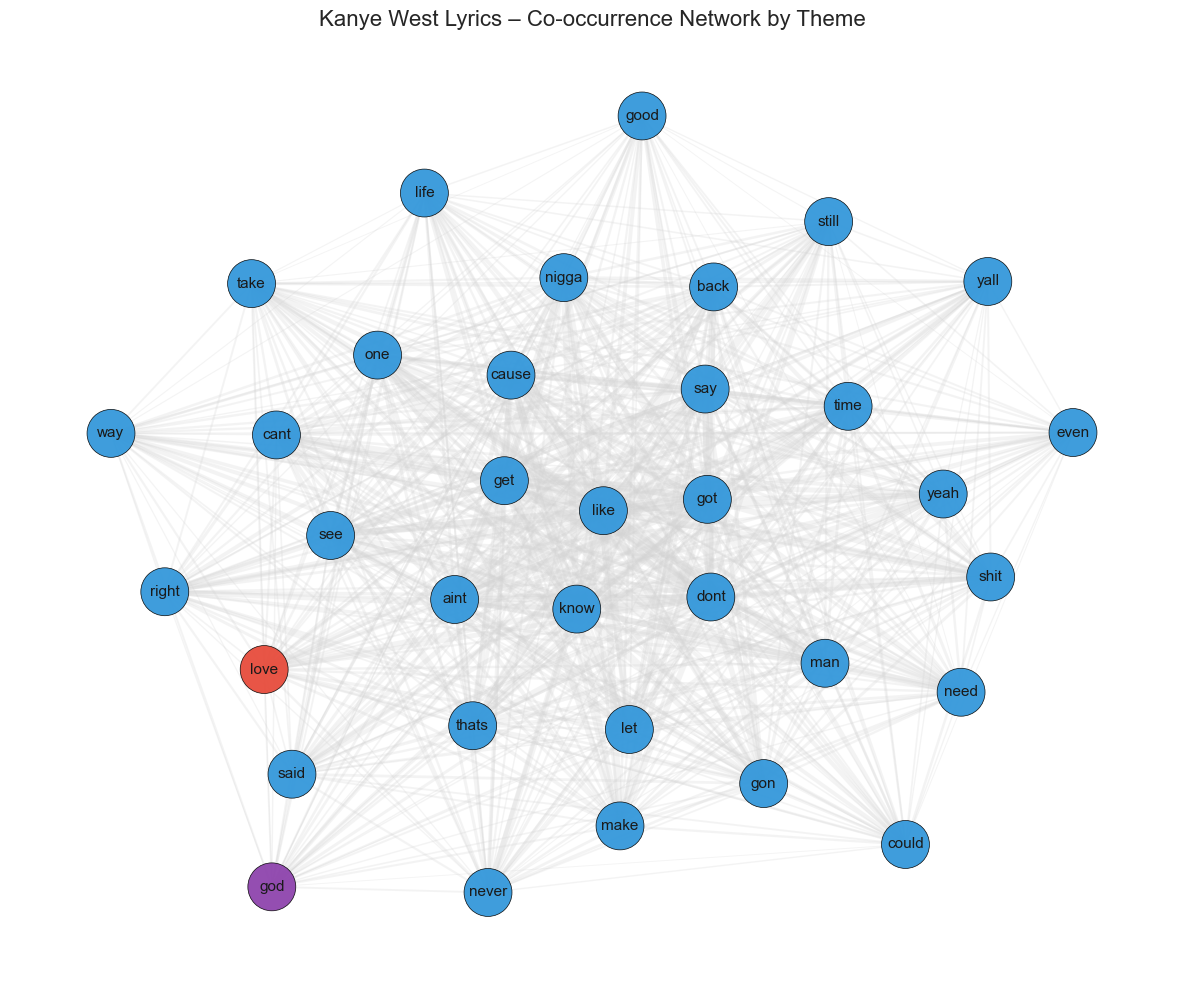

In [74]:
# 9.1 Ensure we have tokens for each lyric block
if "tokens" not in df.columns:
    df["tokens"] = df["lyrics"].apply(clean_text)

# 9.2 Count tokens and filter to reasonably frequent words
token_counts = Counter(t for tokens in df["tokens"] for t in tokens)

MIN_WORD_FREQ = 30   # ignore very rare words
vocab = {w for w, c in token_counts.items() if c >= MIN_WORD_FREQ}

# 9.3 Build co-occurrence pairs
cooc = Counter()
for tokens in df["tokens"]:
    words = sorted(set(t for t in tokens if t in vocab))
    for w1, w2 in itertools.combinations(words, 2):
        cooc[(w1, w2)] += 1

# 9.4 Build weighted graph from co-occurrence counts
G = nx.Graph()
MIN_COOCCUR = 5      # only keep edges for pairs seen together at least this many times

for (w1, w2), w in cooc.items():
    if w >= MIN_COOCCUR:
        G.add_edge(w1, w2, weight=w)

# 9.5 Focus on the top-N most connected words for readability
TOP_N = 35
deg_full = dict(G.degree())
top_nodes = [n for n, _ in sorted(deg_full.items(),
                                  key=lambda x: x[1],
                                  reverse=True)[:TOP_N]]

H = G.subgraph(top_nodes).copy()
degrees = dict(H.degree())

print("Nodes plotted:", len(H.nodes()))
print("Edges plotted:", len(H.edges()))

# 9.6 Layout for visualization
pos = nx.spring_layout(H, k=0.45, iterations=150, seed=42)

## Theme-Colored Co-occurrence Network (Wealth / Religion / Relationships)

# Turn theme lists into sets for quick lookup (assumes THEMES is defined above)
wealth_words = set(THEMES.get("wealth", []))
religion_words = set(THEMES.get("religion", []))
rel_words = set(THEMES.get("relationships", []))

def node_color(word):
    if word in rel_words:
        return "#e74c3c"   # red: relationships
    elif word in religion_words:
        return "#8e44ad"   # purple: religion
    elif word in wealth_words:
        return "#f1c40f"   # gold: wealth
    else:
        return "#3498db"   # blue: other

node_colors = [node_color(n) for n in H.nodes()]

plt.figure(figsize=(12, 10))

node_sizes = [degrees[n] * 35 for n in H.nodes()]
edge_widths = [H[u][v]['weight'] * 0.08 for u, v in H.edges()]

nx.draw_networkx_edges(
    H, pos,
    width=edge_widths,
    edge_color="lightgray",
    alpha=0.25
)

nx.draw_networkx_nodes(
    H, pos,
    node_size=node_sizes,
    node_color=node_colors,
    edgecolors="black",
    linewidths=0.5,
    alpha=0.95
)

nx.draw_networkx_labels(H, pos, font_size=11)

plt.title("Kanye West Lyrics – Co-occurrence Network by Theme", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()



## 10. Save Processed Data (Optional)

Save the processed DataFrame (with tokens, sentiment scores, and theme counts) for later use.


In [75]:
df.to_pickle("kanye_lyrics_processed.pkl")
df.to_csv("kanye_lyrics_processed.csv", index=False)
print("Saved processed data to 'kanye_lyrics_processed.pkl' and 'kanye_lyrics_processed.csv'.")


Saved processed data to 'kanye_lyrics_processed.pkl' and 'kanye_lyrics_processed.csv'.



## 11. Summary

- Downloaded Kanye West's lyrics dataset from Kaggle
- Cleaned and preprocessed the lyrics
- Explored word frequencies
- Performed sentiment analysis
- Built and visualized a word co-occurrence network (network analysis)
- Generated word clouds (overall and per album)
- Quantified theme frequencies for **wealth**, **religion**, and **relationships**

These results support the hypothesis that Kanye's lyrics contain recurring themes related to wealth, religion, and relationships, and that these themes appear consistently across his albums, with some variation.